In [106]:
import pandas as pd
import numpy as np
import geopandas
from geopy import distance
import censusgeocode as cg
import censusdata

from multiprocessing import Pool
from itertools import repeat

In [502]:
# Read in the bagel geolocated data

final_bagel_data_geo = pd.read_pickle("final_bagel_data_geo.pkl")

In [604]:
# Use FCC API to extract information for each lat/long and its associated census tract

census_tracts = []

for index, row in final_bagel_data_geo.iterrows():
    
    lat = pd.to_numeric(row['lat_gmap'])
    lng = pd.to_numeric(row['lng_gmap'])
    url = 'https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}5&format=json'.format(lat,lng)
    response = requests.get(url)
    data = response.json()['Block']['FIPS']
    df = pd.DataFrame({'lng_gmap': [lng],'lat_gmap':[lat], 'fips':[data]})
    census_tracts.append(df)

In [610]:
# Concat information about census

census_tracts_clean = pd.concat(census_tracts).drop_duplicates()

In [612]:
# Merge the clean census data

final_bagel_data_geo_clean = final_bagel_data_geo\
.merge(census_tracts_clean, on = ['lat_gmap','lng_gmap'], how = "left")

final_bagel_data_geo_clean['county_tract_bagel'] = final_bagel_data_geo_clean.fips.str.slice(start = 2, stop =11)

In [616]:
# Read in the census tract information and the centroids for each census tract

tract_cen = pd.read_csv("https://www2.census.gov/geo/docs/reference/cenpop2010/tract/CenPop2010_Mean_TR36.txt", dtype = "object")

In [617]:
# Keep only NYC census tracts

tract_cen_nyc = tract_cen[tract_cen.COUNTYFP.isin(['005','047','061','081','085'])].reset_index(drop = True)
tract_cen_nyc['county_tract'] = tract_cen_nyc['COUNTYFP'] + tract_cen_nyc['TRACTCE']
tract_cen_nyc['LONGITUDE'] = pd.to_numeric("-" + tract_cen_nyc['LONGITUDE'].str[2:])
tract_cen_nyc['LATITUDE'] = pd.to_numeric(tract_cen_nyc['LATITUDE'])

In [629]:
# Function to find distance to all bagel shops from the centroid of each census tract
# Note, this can be improved, this takes a while to run

tract_cen_bagels = pd.DataFrame()

for tract in tract_cen_nyc.county_tract:
    df = final_bagel_data_geo_clean.copy()
    df['lat_nyc'] = tract_cen_nyc[tract_cen_nyc.county_tract == tract]['LATITUDE'].values[0]
    df['lng_nyc'] = tract_cen_nyc[tract_cen_nyc.county_tract == tract]['LONGITUDE'].values[0]
    df['county_tract'] =  tract
    df['dist'] =  df.apply(lambda row: distance.distance((row.lat_nyc, row.lng_nyc),\
                                       (row.lat_gmap, row.lng_gmap))\
                                       .miles, axis=1)
    
    tract_cen_bagels = tract_cen_bagels.append(df).reset_index(drop = True)

In [620]:
# Get population estimates from census for 2019

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)

pop = censusdata.download('acs5', 2019, censusdata.censusgeo([('state', '36'), ('county', '*'), ('tract', '*')]),['B01003_001E','GEO_ID'])
pop = pop[['GEO_ID','B01003_001E']].rename(columns = {'B01003_001E':'total_pop'})
pop['county_tract'] = pop['GEO_ID'].str.slice(start =11, stop = 20)
pop['state_county_tract'] = pop['GEO_ID'].str.slice(start =9, stop = 20)
pop_clean = pop.drop(['GEO_ID'], axis = 1).reset_index(drop = True)

In [716]:
# Source: https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.2019.html
# 2019 file is based on 2010 census

area = pd.read_csv("https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2019_Gazetteer/2019_gaz_tracts_36.txt", dtype = "object", sep ="\t")

In [724]:
# Combine data to get per capita
# May want to consider not letting manhattan census tracts be assigned any brooklyn or queens bagel shops
# The threshold is is the distanc must be below 0.6 miles

tract_cen_bagels_clean = tract_cen_bagels[(tract_cen_bagels.county_tract_bagel == tract_cen_bagels.county_tract) | (tract_cen_bagels.dist <0.6)]\
    [['county_tract','name']]\
    .merge(tract_cen_nyc[['county_tract']], on = 'county_tract', how = 'right')\
    .groupby(['county_tract'])\
    .count()\
    .sort_values(['name'], ascending = False)\
    .merge(pop_clean, on = "county_tract", how = "left")\
    .rename(columns = {'name':'count_bagel_shops'})\
    .merge(area[['GEOID','ALAND_SQMI']], left_on = 'state_county_tract', right_on = 'GEOID', how = 'left')\
    .drop(['GEOID'], axis = 1)

In [725]:
# Get the bagel per capita estimates

tract_cen_bagels_clean['bagel_per_capita'] = tract_cen_bagels_clean['count_bagel_shops']/tract_cen_bagels_clean['total_pop']*1000
tract_cen_bagels_clean['bagel_per_capita_sq'] = np.sqrt(tract_cen_bagels_clean['bagel_per_capita'])

<AxesSubplot:>

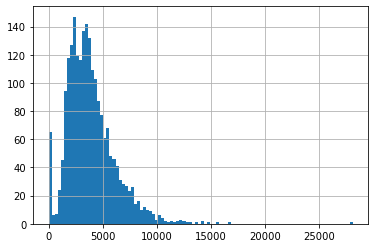

In [700]:
# Look at the distribution of total populations

tract_cen_bagels_clean.total_pop.hist(bins=100)

<AxesSubplot:>

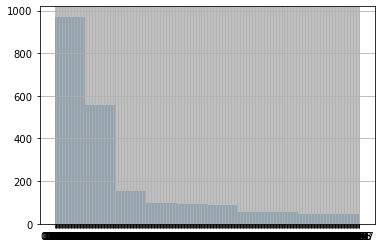

In [731]:
tract_cen_bagels_clean.ALAND_SQMI.hist()

In [ ]:
# Look at one example of a high bagel shop per capita

tract_cen_bagels[((tract_cen_bagels.county_tract_bagel == tract_cen_bagels.county_tract) | (tract_cen_bagels.dist <0.6)) \
                 & (tract_cen_bagels.county_tract == "047054300")].reset_index()

<AxesSubplot:xlabel='total_pop', ylabel='count_bagel_shops'>

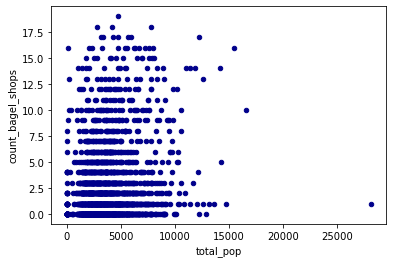

In [736]:
tract_cen_bagels_clean.plot.scatter(y='count_bagel_shops',
                      x='total_pop',
                      c='DarkBlue')

In [707]:
tract_cen_bagels_clean[tract_cen_bagels_clean.total_pop > 100].to_csv("tract_cen_bagels_clean.csv", index = False)